<!-- :Author: Arthur Goldberg <Arthur.Goldberg@mssm.edu> -->
<!-- :Date: 2020-07-13 -->
<!-- :Copyright: 2020, Karr Lab -->
<!-- :License: MIT -->

# A stochastic epidemic model

Epidemics occur when infectious diseases spread through a susceptible population.
Models that classify individuals by their infectious state are widely used to analyze and predict the dynamics of epidemics.
A well-known and simple approach considers these three infectious states:

* *Susceptible*: an individual who can become infected if exposed
* *Infectious*: an individual who is infected, and can transmit the infection to a person who is susceptible
* *Recovered*: an individual who has recovered from an infection, and is not susceptible to being reinfected

Dynamic analyses of spreading infection that employ these states are called Susceptible, Infectious, or Recovered (SIR) epidemic models.
SIR models are characterized by the initial population of individuals in each state and the rate at which individuals transition between states.

![SIR model states and transitions](SIR_Flow_Diagram.svg)
*SIR model states and transitions*<sup>1</sup>

In this figure, the transitions between states are labeled with the standard SIR transition rates, in individuals per unit time.
S and I represent the number of individuals in states Susceptible and Infectious, respectively. &beta; and &gamma; are model parameters.

We present a stochastic SIR model that demonstrates core features of DE-Sim.
Epidemics must be modelled stochastically when the number of infectious individuals is small or when variability in the rates of transitions between model states influences an epidemic's trajectory.

The SIR model below uses DE-Sim to implement a continuous-time Markov chain model, as described in section 3 of Allen (2017).
It represents transitions by individuals to a new state as discrete events and selects each transition and its timing by random samples of their distributions.
See Allen (2017) for a mathematical derivation of the approach.

Let's implement and use the SIR model.
First, use `pip` to install `de_sim`.

1: Diagram by Viki Male and remade by Gregory Kaiser, licensed under [Creative Commons license]().

In [2]:
" Example DE-Sim implementation of stochastic Susceptible, Infectious, or Recovered (SIR) epidemic model "

import enum
import numpy

import de_sim


class TransitionMessage(de_sim.EventMessage):
    "Message for all model transitions"
    msg_field_names = ['transition_type']


class StateTransitionType(enum.Enum):
    " State transition types "
    s_to_i = 'Transition from Susceptible to Infectious'
    i_to_r = 'Transition from Infectious to Recovered'


MESSAGE_TYPES = [TransitionMessage]


class SIR(de_sim.SimulationObject):
    """ Implement a Susceptible, Infectious, or Recovered (SIR) epidemic model

    This example uses DE-Sim to implement a continuous-time Markov chain (CTMC) SIR
    epidemic model, as described in section 3 of Allen (2017).

    Allen, L.J., 2017. A primer on stochastic epidemic models: Formulation, numerical
    simulation, and analysis. Infectious Disease Modelling, 2(2), pp.128-142.

    Attributes:
        s (`int`): number of susceptible subjects
        i (`int`): number of infectious subjects
        N (`int`): total number of susceptible subjects, a constant
        beta (`float`): SIR beta parameter
        gamma (`float`): SIR gamma parameter
        random_state (`numpy.random.RandomState`): a random state
    """
    def __init__(self, name, s, i, N, beta, gamma):
        """ Initialize an SIR instance

        Args:
            name (`str`): the instance's name
            s (`int`): initial number of susceptible subjects, s(0)
            i (`int`): initial number of infectious subjects, i(0)
            N (`int`): total number of susceptible subjects, a constant
            beta (`float`): SIR beta parameter
            gamma (`float`): SIR gamma parameter
            random_state (`numpy.random.RandomState`): random state
        """
        self.s = s
        self.i = i
        self.N = N
        self.beta = beta
        self.gamma = gamma
        self.random_state = numpy.random.RandomState()
        self.history = []
        super().__init__(name)

    def init_before_run(self):
        " Initialize before a simulation run. Send the initial events. "
        self.schedule_next_event()

    def schedule_next_event(self):
        " Schedule the next SIR event. "
        rates = {'s_to_i': self.beta * self.s * self.i / self.N,
                 'i_to_r': self.gamma * self.i}
        lambda_val = rates['s_to_i'] + rates['i_to_r']
        if lambda_val == 0:
            return

        tau = self.random_state.exponential(1.0/lambda_val)
        prob_s_to_i = rates['s_to_i'] / lambda_val
        if self.random_state.random_sample() < prob_s_to_i:
            self.send_event(tau, self, TransitionMessage(StateTransitionType.s_to_i))
        else:
            self.send_event(tau, self, TransitionMessage(StateTransitionType.i_to_r))

    def handle_state_transition(self, event):
        """ Handle an infectious state transition

        Args:
            event (`de_sim.Event`): simulation event that contains an event message
        """
        transition_type = event.message.transition_type
        if transition_type is StateTransitionType.s_to_i:
            self.s -= 1
            self.i += 1
        elif transition_type is StateTransitionType.i_to_r:
            self.i -= 1
        self.schedule_next_event()


    event_handlers = [(TransitionMessage, 'handle_state_transition')]

    # register the message types sent
    messages_sent = MESSAGE_TYPES

Next we introduce the DE-Sim's checkpointing feature.
A simulation's state is conceptualized as a set of values, and the state of its random number generator.
A checkpointing object, an instance of `CheckpointSimulationObject`, will periodically checkpoint the simulation's state.
It must be given an object that complies with the interface defined in `AccessStateObjectInterface`, which implements methods that return the simulation's state (`get_checkpoint_state`) and random number generator state (`get_random_state`), as shown in `AccessSIRObjectState` below.

In [3]:
from de_sim.checkpoint import AccessCheckpoints, Checkpoint
from de_sim.simulation_checkpoint_object import (AccessStateObjectInterface,
                                                 CheckpointSimulationObject)

class AccessSIRObjectState(AccessStateObjectInterface):
    """ Get the state of an SIR object

    Attributes:
        sir (`obj`): an SIR object
        random_state (`numpy.random.RandomState`): a random state
    """

    def __init__(self, sir):
        self.sir = sir
        self.random_state = sir.random_state

    def get_checkpoint_state(self, time):
        """ Get the SIR simulation's state

        Args:
            time (`float`): current time; ignored
        """
        return dict(s=self.sir.s,
                    i=self.sir.i)

    def get_random_state(self):
        """ Get the SIR object's random state
        """
        return self.random_state.get_state()

The next cell defines code to run the SIR model and visualize its predictions.
An instance of `CheckpointSimulationObject` is added to the simulation. It needs a name, its checkpointing period, a directory in which to save checkpoints, and an object that can access the simulation's state, like `AccessSIRObjectState` above.
The `AccessCheckpoints` class obtains checkpoint data from the directory storing them.

In [4]:
import pandas

class RunSIR(object):

    def __init__(self, checkpoint_dir):
        self.checkpoint_dir = checkpoint_dir

    def simulate(self, recording_period, max_time, **sir_args):
        """ Create and run an SIR simulation

        Args:
            recording_period (`float`): interval between state checkpoints
            max_time (`float`): simulation end time
            sir_args (`dict`): arguments for an SIR object
        """
        # create a simulator
        simulator = de_sim.Simulator()

        # create an SIR instance
        self.sir = sir = SIR(**sir_args)
        simulator.add_object(sir)

        # create a checkpoint simulation object
        access_state_object = AccessSIRObjectState(sir)
        checkpointing_obj = CheckpointSimulationObject('checkpointing_obj',
                                                       recording_period,
                                                       self.checkpoint_dir,
                                                       access_state_object)
        simulator.add_object(checkpointing_obj)

        # initialize simulation, which sends the SIR instance an initial event message
        simulator.initialize()

        # run the simulation
        event_num = simulator.simulate(max_time).num_events

    def last_checkpoint(self):
        """ Get the last checkpoint of the last simulation run

        Returns:
            `Checkpoint`: the last checkpoint of the last simulation run
        """
        access_checkpoints = AccessCheckpoints(self.checkpoint_dir)
        last_checkpoint_time = access_checkpoints.list_checkpoints()[-1]
        return access_checkpoints.get_checkpoint(time=last_checkpoint_time)

    def history_to_dataframe(self):
        """ Convert the checkpoint history to a Pandas dataframe

        Returns:
            `pandas.DataFrame`: SIR values are columns, rows are timepoints
        """
        fields = ('s', 'i', 'r')
        hist = []
        index = []
        access_checkpoints = AccessCheckpoints(self.checkpoint_dir)
        for checkpoint_time in access_checkpoints.list_checkpoints():
            state = access_checkpoints.get_checkpoint(time=checkpoint_time).state
            state_as_list = [state['s'], state['i'], self.sir.N - state['s'] - state['i']]
            hist.append(dict(zip(fields, state_as_list)))
            index.append(checkpoint_time)
        return pandas.DataFrame(hist)

Let's use the model to view an epidemic's predictions.
We use parameters from Allen (2017), and print and plot the trajectory of a single simulation.
Since the model is stochastic, each run produces a different trajectory.

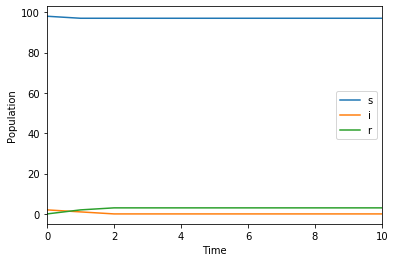

In [5]:
import tempfile

sir_args = dict(name='sir',
                s=98,
                i=2,
                N=100,
                beta=0.3,
                gamma=0.15)
with tempfile.TemporaryDirectory() as tmpdirname:
    run_sir = RunSIR(tmpdirname)
    run_sir.simulate(10, 100, **sir_args)

    # print and plot an epidemic's predicted trajectory
    sir_data_frame = run_sir.history_to_dataframe()
    axes = sir_data_frame.plot()
    axes.set_xlabel("Time")
    rv = axes.set_ylabel("Population")

An important prediction generated by the SIR model is the severity of the epidemic, which can be summarized by the fraction of people who became infected.
We run an ensemble of simulations and examine the predicted distribution of severity.

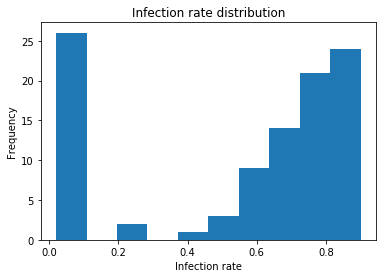

In [6]:
import math

num_sims = 100
infection_rates= []

for _ in range(num_sims):
    with tempfile.TemporaryDirectory() as tmpdirname:
        run_sirs = RunSIR(tmpdirname)
        run_sirs.simulate(recording_period=10, max_time=60, **sir_args)
        # infection rate = infectious + recovered
        # N = s + i + r => i + r = N - s
        final_state = run_sirs.last_checkpoint().state
        N = sir_args['N']
        infection_rate = (N - final_state['s'])/N
        infection_rates.append(infection_rate)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
rv = plt.hist(infection_rates)
ax.set_title('Infection rate distribution')
ax.set_xlabel('Infection rate')
rv = ax.set_ylabel('Frequency')

As predicted by Allen's (2017) analysis, for the parameters in `sir_args` the infection rate distribution is bimodal. Most of the epidemics infect a majority of the population and a small fraction of them (Allen predicts 25%) burn out and infect only a minority of the population.

The simple model above only touches the surface of epidemic modeling. Many extensions are possible:

* A spatial model with multiple geographic areas: each area would be represented by an instance of SIR.
* An extension of the spatial model that also represents travel between geographic areas
* A model that represents individuals in more states, such as multiple infectious states which distinguish between asymptomatic and symptomatic individuals, with a lower transmission parameter &beta; for symptomatic individuals who would likely isolate while recovering
* A model that can model both small and large populations: it would use the stochastic approach above to integrate small populations and ODEs to integrate large populations. Models and simulators that use multiple integration methods are called *multi-algorithmic*.

We encourage you to experiment with different parameters for this model and build your own models!

**References**

Allen, L.J., 2017. A primer on stochastic epidemic models: Formulation, numerical
simulation, and analysis. Infectious Disease Modelling, 2(2), pp.128-142.